# Forecasting Case Study
Lei You

In [61]:
from typing import Optional, List, Dict, Any 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation as prophet_cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import add_changepoints_to_plot

from sklearn.model_selection import ParameterGrid

from scipy.signal import find_peaks, argrelextrema

pd.set_option('display.max_rows', 1000)

## Data Exploration

In [62]:
df_ = pd.read_csv('data.csv', sep=';', parse_dates=['date'])
df = df_.copy()

## Visulization

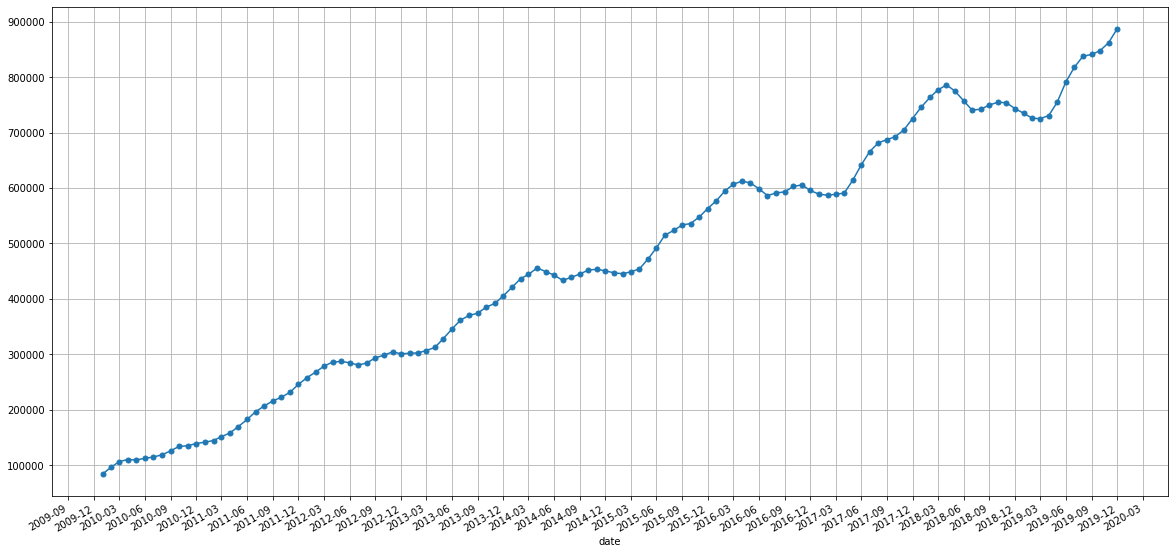

In [63]:
fig, ax = plt.subplots(figsize=(20,10))
df.set_index('date')['purchase_amount'].plot(ax=ax, x_compat=True, markersize=5, marker='o', grid=True)
ax.xaxis.set_major_locator(mdates.MonthLocator([3,6,9,12]))
plt.show()



In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             132 non-null    datetime64[ns]
 1   purchase_amount  120 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.2 KB


### Changepoints

Changepoints can be extracted from the data, which provide guidance on hyperparameters setting of the model.

In [65]:
peaks = argrelextrema(np.array(df['purchase_amount'].dropna()), np.greater)
valleys = argrelextrema(np.array(df['purchase_amount'].dropna()), np.less)
changepoints = sorted(list(set(df['date'].loc[peaks].dt.strftime('%Y-%m-%d').tolist() + df['date'].loc[valleys].dt.strftime('%Y-%m-%d').tolist())))

In [66]:
changepoints

['2010-04-01',
 '2010-05-01',
 '2012-05-01',
 '2012-07-01',
 '2012-11-01',
 '2012-12-01',
 '2014-04-01',
 '2014-07-01',
 '2014-11-01',
 '2015-02-01',
 '2016-04-01',
 '2016-07-01',
 '2016-11-01',
 '2017-02-01',
 '2018-04-01',
 '2018-07-01',
 '2018-10-01',
 '2019-03-01']

### Seasonality

As a step further, we try to identify seasonality from the changepoints (peaks).

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


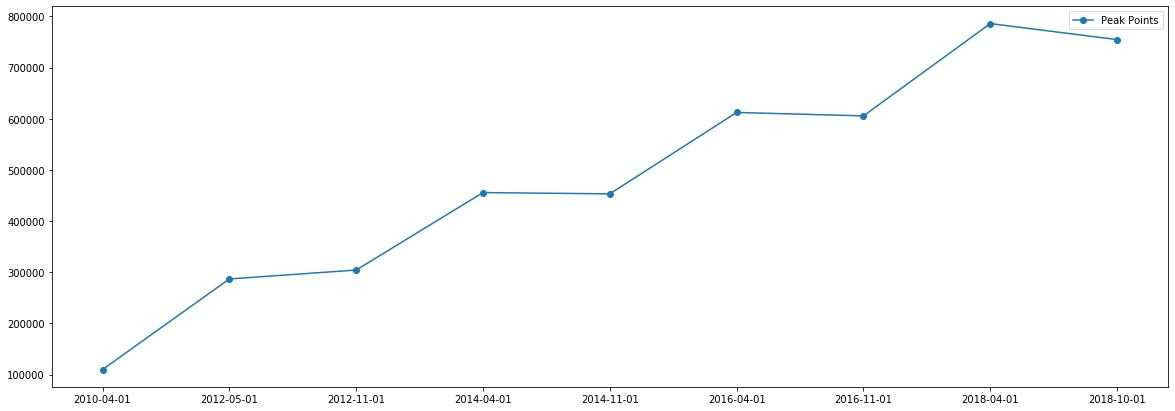

In [67]:
peaks, properties = find_peaks(df['purchase_amount'].dropna(), height=0)
peaks_date = df['date'].loc[peaks].dt.strftime('%Y-%m-%d').tolist()

fig, ax = plt.subplots(figsize=(20,7))
ax.plot(peaks_date, properties['peak_heights'], marker='o');
plt.legend(['Peak Points'])
plt.show();

It is quite apparently that bi-yearly seasonality applies to the data.

## Model Prototype

### Dataset Preparation

In [68]:
train_test_split_date = df[df.purchase_amount.notnull()]['date'].max()
train_ = df[df.date <= train_test_split_date]
test_  = df[df.date > train_test_split_date]

train = train_.rename(columns={'date':'ds', 'purchase_amount':'y'})
test  = test_.rename(columns={'date':'ds', 'purchase_amount':'y'})

### Model Fiting with Grid Search

The main idea is to use Facebook Prophet model to fit the data, with 1) **changepoints** and 2) **bi-yearly seasonality** as hyperparameters settings.

In [69]:
def fit_model(df: pd.DataFrame, model_params: Dict[str, List[Any]]):
    """Fits Prophet model.
    
    Args:
        df (pandas DataFrame): training data
        model_params (dict): dictionary of model hyperparameters      
    """
    
    m = Prophet(
                weekly_seasonality=False,
                daily_seasonality=False,
                growth=model_params['growth_model'], 
                seasonality_mode=model_params['seasonality_mode'],
                changepoints=model_params['changepoints'],
                changepoint_prior_scale=model_params['changepoint_prior_scale'],
    )

    # Add bi-yearly seasonality
    m.add_seasonality(name='bi-yearly', period=365*2, fourier_order=model_params['yearly_fourier_order'], 
                        prior_scale=model_params['yearly_seasonality_prior_scale'], 
                        mode=model_params['seasonality_mode'])    

    m.fit(df);
        
    return m

In [70]:
def train_model(train: pd.DataFrame, model_params: Dict[str, Any]):
    """Training Prophet model with given parameters
    
    Args:
        df (pandas DataFrame): training data
    """
    
    # fit model
    model = fit_model(train, model_params)
    
    # cross validation
    df_cv = prophet_cross_validation(model, period='180 days', horizon='365 days')
    df_perform = performance_metrics(df_cv)
    cv_results = df_perform[['mse', 'rmse', 'mae', 'mape']].mean().to_dict()
    
    return cv_results, model

In [71]:
# MODEL_PARAMS_GRID = {'growth_model': ['linear'],
#                     'seasonality_mode': ['multiplicative'],
#                     'changepoint_prior_scale':  [0.4,0.6,0.8],
#                     'changepoints': [changepoints],
#                     'yearly_seasonality_prior_scale':  [0.1,1,10],
#                     'yearly_fourier_order': [4,6,8],
#                     }

MODEL_PARAMS_GRID = {'growth_model': ['linear'],
                    'seasonality_mode': ['multiplicative'],
                    'changepoint_prior_scale':  [0.4],
                    'changepoints': [changepoints],
                    'yearly_seasonality_prior_scale':  [0.1],
                    'yearly_fourier_order': [4],
                    }

def grid_search(df: pd.DataFrame, model_params_grid: Optional[Dict[str, Any]]=MODEL_PARAMS_GRID, metric='mape'):
    """Grid search over a set of hyperparametsrs
    
    Args:
        df (pandas DataFrame): training data
        model_params_grid (dict, optional): dictionary of hyperparameters grid
    """
    
    params_list = list(ParameterGrid(model_params_grid))

    training_results = pd.DataFrame()
    for i, params_set in enumerate(params_list):
        print(f'Iteration {i+1} out of {len(params_list)}')
        print(f'Fitting with parameter set: \n{params_set}')
        cv_results, model = train_model(df, params_set)
        training_results = training_results.append({'params_set': params_set, 'cv_results': cv_results}, ignore_index=True)
        
    training_results = training_results.reset_index(drop=True)
    
    best_i = 0
    best_params_set = training_results.loc[best_i]['params_set']
    minimum_error = training_results.loc[best_i]['cv_results'][metric]
    for i in range(training_results.shape[best_i]):
        row = training_results.loc[i]
        cv_results = row['cv_results']
        params_set = row['params_set']
        if minimum_error > cv_results[metric]:
            minimum_error = cv_results[metric]
            best_params_set = params_set
            best_i = i
            
            
    print(f'Fitting with best parameter set: \n{best_params_set}')
    _, model = train_model(df, best_params_set)
            
    return training_results.loc[best_i], best_params_set, model


In [72]:
training_results, best_params_set, m = grid_search(train, metric='mape')

Iteration 1 out of 1
Fitting with parameter set: 
{'changepoint_prior_scale': 0.4, 'changepoints': ['2010-04-01', '2010-05-01', '2012-05-01', '2012-07-01', '2012-11-01', '2012-12-01', '2014-04-01', '2014-07-01', '2014-11-01', '2015-02-01', '2016-04-01', '2016-07-01', '2016-11-01', '2017-02-01', '2018-04-01', '2018-07-01', '2018-10-01', '2019-03-01'], 'growth_model': 'linear', 'seasonality_mode': 'multiplicative', 'yearly_fourier_order': 4, 'yearly_seasonality_prior_scale': 0.1}


INFO:fbprophet:Making 13 forecasts with cutoffs between 2013-01-01 00:00:00 and 2018-12-01 00:00:00



Fitting with best parameter set: 
{'changepoint_prior_scale': 0.4, 'changepoints': ['2010-04-01', '2010-05-01', '2012-05-01', '2012-07-01', '2012-11-01', '2012-12-01', '2014-04-01', '2014-07-01', '2014-11-01', '2015-02-01', '2016-04-01', '2016-07-01', '2016-11-01', '2017-02-01', '2018-04-01', '2018-07-01', '2018-10-01', '2019-03-01'], 'growth_model': 'linear', 'seasonality_mode': 'multiplicative', 'yearly_fourier_order': 4, 'yearly_seasonality_prior_scale': 0.1}


INFO:fbprophet:Making 13 forecasts with cutoffs between 2013-01-01 00:00:00 and 2018-12-01 00:00:00


In [73]:
training_results['cv_results']

{'mse': 644809854.4051764,
 'rmse': 23039.171039528275,
 'mae': 19449.14950006086,
 'mape': 0.034677147415665036}

### Forecasting

In [74]:
forecasting_years = 5

In [75]:
future_months = 12 * forecasting_years 
future = m.make_future_dataframe(periods=future_months, freq='m')

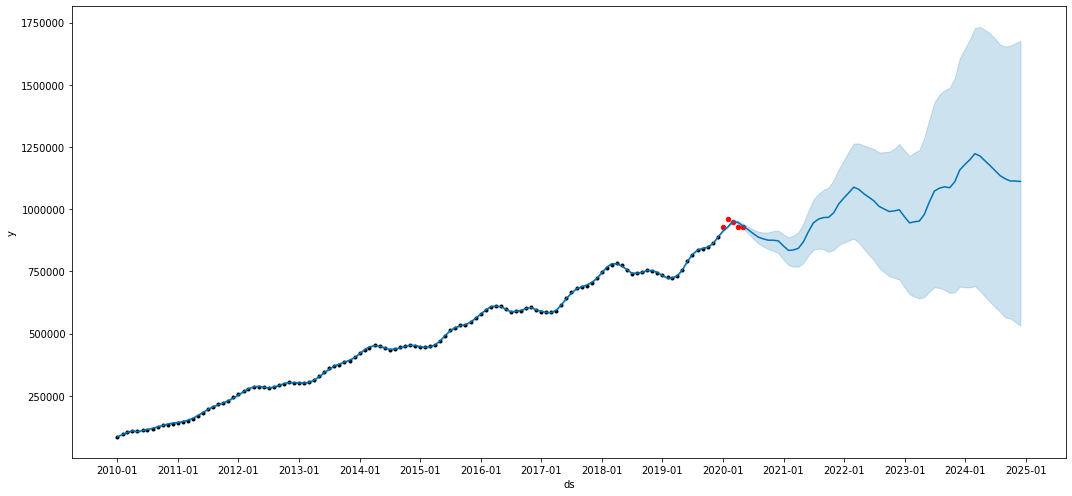

In [76]:
forecast = m.predict(future)

fig, ax = plt.subplots(figsize=(15,7))
m.plot(forecast, ax=ax);
ax.xaxis.set_major_locator(mdates.MonthLocator([1]))


# Some fake data for visulization. One can put the real test data here to check the forecasting performance visually.
fake_test_data = pd.DataFrame(
    {'ds': [pd.Timestamp('2020-01-01'), 
            pd.Timestamp('2020-02-01'), 
            pd.Timestamp('2020-03-01'), 
            pd.Timestamp('2020-04-01'), 
            pd.Timestamp('2020-05-01')],
     'y' : [929355,960661,950000,930000,929355]
    }
)
fake_test_data.plot(x='ds',y='y', ax=ax, kind='scatter', color='r')

plt.show();

### Grid Search Result

In [77]:
best_params_set

{'changepoint_prior_scale': 0.4,
 'changepoints': ['2010-04-01',
  '2010-05-01',
  '2012-05-01',
  '2012-07-01',
  '2012-11-01',
  '2012-12-01',
  '2014-04-01',
  '2014-07-01',
  '2014-11-01',
  '2015-02-01',
  '2016-04-01',
  '2016-07-01',
  '2016-11-01',
  '2017-02-01',
  '2018-04-01',
  '2018-07-01',
  '2018-10-01',
  '2019-03-01'],
 'growth_model': 'linear',
 'seasonality_mode': 'multiplicative',
 'yearly_fourier_order': 4,
 'yearly_seasonality_prior_scale': 0.1}

## Post-Analysis of Forecasting

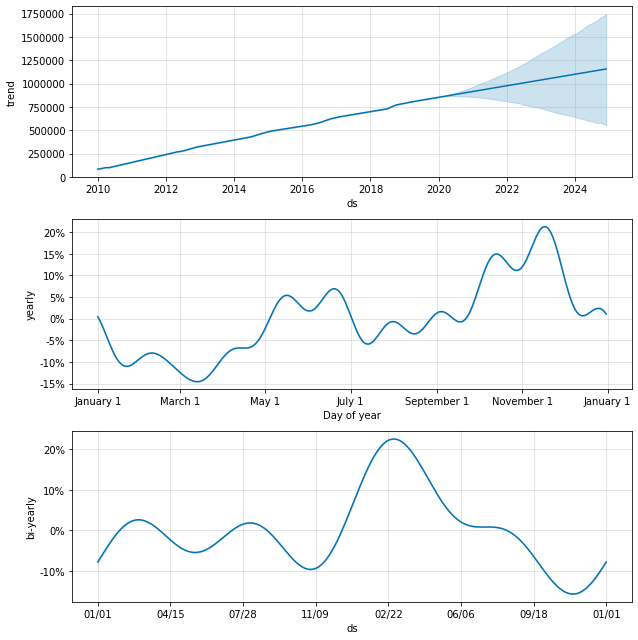

In [78]:
m.plot_components(forecast);

In [79]:
df_cv = prophet_cross_validation(m, period='180 days', horizon='365 days')

INFO:fbprophet:Making 13 forecasts with cutoffs between 2013-01-01 00:00:00 and 2018-12-01 00:00:00


In [80]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2013-02-01,316296.181692,315431.708910,317121.980613,302365.81,2013-01-01
1,2013-03-01,307061.014472,305832.028470,308135.837647,306584.12,2013-01-01
2,2013-04-01,321871.050489,319652.890981,323460.038744,312128.86,2013-01-01
3,2013-05-01,344861.632308,340487.019209,347977.292132,327919.09,2013-01-01
4,2013-06-01,368899.801470,361412.074122,373901.497547,345348.82,2013-01-01
5,2013-07-01,387849.782803,377580.446649,395141.377103,361235.75,2013-01-01
6,2013-08-01,403960.078253,389949.320507,414509.131681,369962.12,2013-01-01
7,2013-09-01,418191.554181,401070.575578,432445.298242,373850.49,2013-01-01
8,2013-10-01,425587.990983,405035.689290,443113.952977,384817.16,2013-01-01
9,2013-11-01,439040.107108,414116.210533,461078.474824,391491.23,2013-01-01
